# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [98]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="twitter_id")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы.

In [ ]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("n.teplyakova") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [37]:
NOISE = -1

class Clustering:
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, eps=0.5, min_pts=5):
        """
        Please add necessary algorithm parameters to class constructor.
        """
        self.eps = eps
        self.min_pts = min_pts
        return
    
    def region_query(self, point_ind):
        return [ind for ind, p in enumerate(self.data) if self.distance_matrix[ind][point_ind] <= self.eps]
        
    
    def expand_cluster(self, point_ind, neighbour_pts, cur_cluster):
        #add point to cluster
        self.labels[point_ind] = cur_cluster
        while len(neighbour_pts):
            ind = neighbour_pts.pop(0)
            if not self.visited[ind]:
                self.visited[ind] = True
                new_neighbour_pts = self.region_query(ind)
                if len(new_neighbour_pts) >= self.min_pts:
                    neighbour_pts.extend(new_neighbour_pts)
            
            if self.labels[ind] == 0:
                self.labels[ind] = cur_cluster
        
    
    def fit(self, X, y=None):
        """
        Use data matrix X to compute model parameters
        """
        #cluster labels begin with 1
        n_samples = len(X)
        self.distance_matrix = ss.distance.squareform(ss.distance.pdist(X, 'euclidean'))
        self.visited = np.zeros(n_samples, dtype=np.bool_)
        self.labels = np.zeros(n_samples, dtype = np.int32)
        self.data = X
        
        #zero corresponds to NOT VISITED
        cur_cluster = 0
        for i in xrange(n_samples):                
            if self.visited[i]:
                continue
            
            self.visited[i] = True
            neighbour_pts = self.region_query(i)
            if len(neighbour_pts) < self.min_pts:
                self.labels[i] = NOISE
            else:
                cur_cluster += 1
                self.expand_cluster(i, neighbour_pts, cur_cluster)
        
        self.labels[self.labels > 0] = self.labels[self.labels > 0] - 1
        return self
    
    def predict(self, X):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return self.labels
    
    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X)

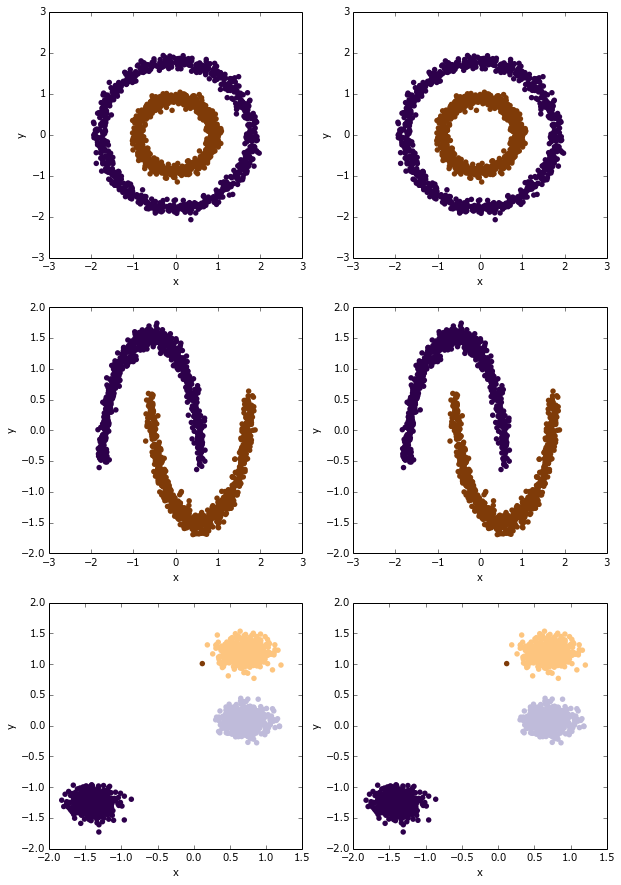

In [38]:
import sklearn.preprocessing as sp

n_samples = 1500
noisy_circles = ds.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = ds.make_moons(n_samples=n_samples, noise=.05)
blobs = ds.make_blobs(n_samples=n_samples, random_state=8)

datasets = [noisy_circles, noisy_moons, blobs]

pl.figure(figsize=(10, 15))
plot_num = 1
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    X = sp.StandardScaler().fit_transform(X)
    
    my_pred = Clustering(eps=.2).fit_predict(X)
    sklearn_pred = sc.DBSCAN(eps=.2).fit_predict(X)
    
    pl.subplot(3, 2, plot_num)
    pl.scatter(X[:, 0], X[:, 1], c=sklearn_pred, cmap=pl.cm.PuOr, lw=0, s=30)
    plt.xlabel('x')
    plt.ylabel('y')
    
    pl.subplot(3, 2, plot_num+1)
    pl.scatter(X[:, 0], X[:, 1], c=my_pred, cmap=pl.cm.PuOr, lw=0, s=30)
    plt.xlabel('x')
    plt.ylabel('y')
    
    plot_num += 2

pl.show()

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

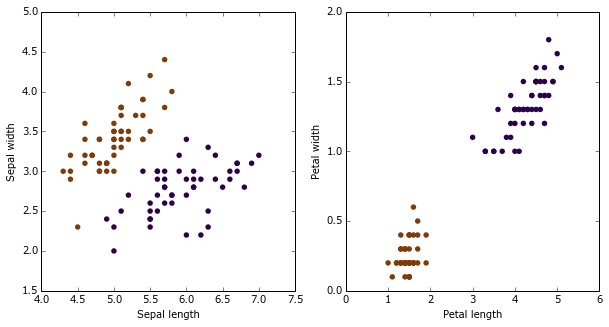

In [39]:
iris = ds.load_iris()

x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [40]:
pred_iris = Clustering().fit_predict(x_iris)

print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 0.87


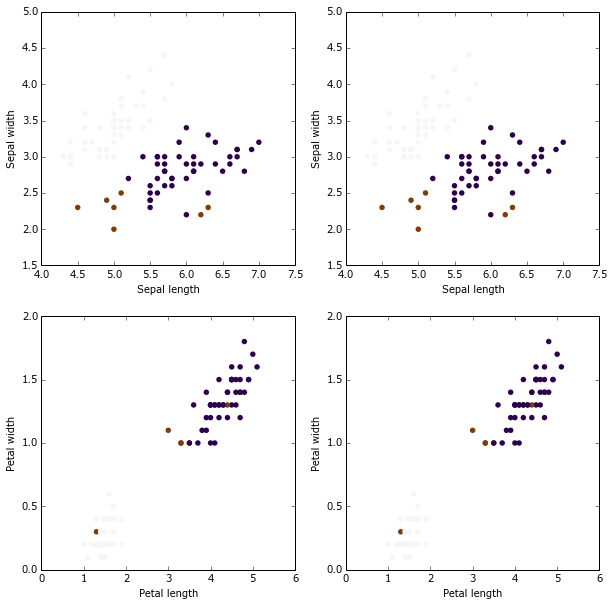

In [41]:
pl.figure(figsize=(10, 10))
pl.subplot(2, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(2, 2, 2)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=g_pred, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(2, 2, 3)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')

pl.subplot(2, 2, 4)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=g_pred, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')

pl.show()

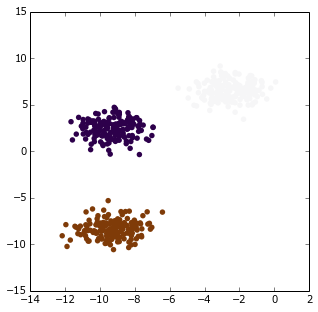

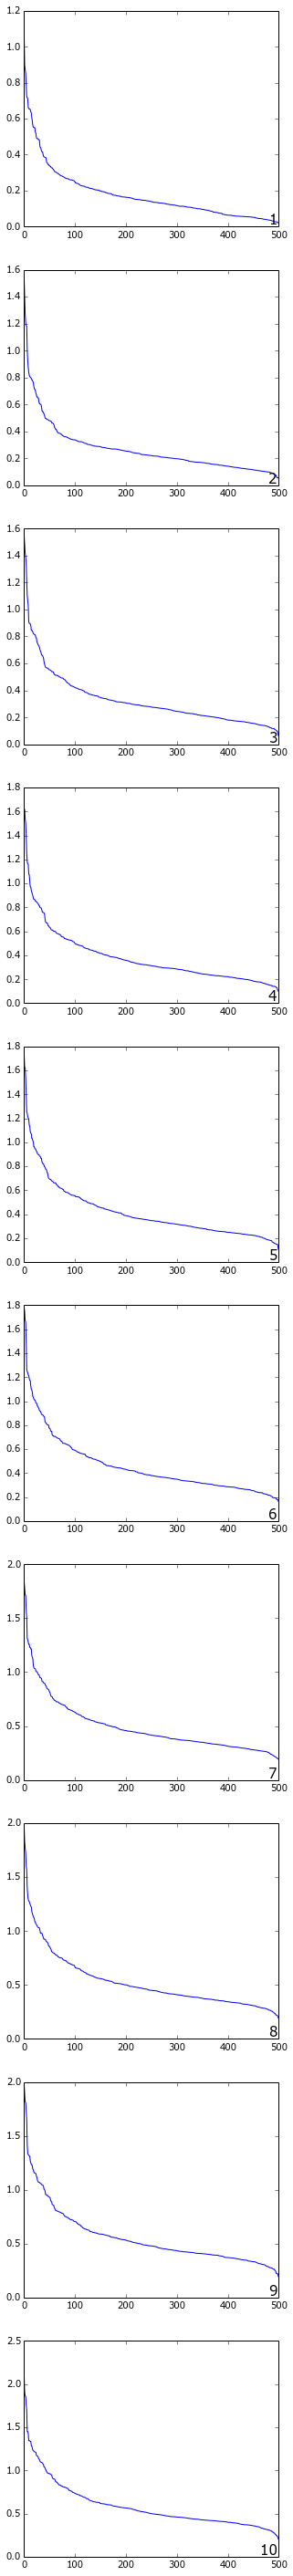

In [42]:
import sklearn.neighbors as nb
def k_dist(X, k=5):
    """
    Count distance from every point in the dataset
    to its k-th neighbour
    """
    neigh = nb.NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    dist, ind = neigh.kneighbors()
    dist = np.max(dist, axis=1)
    dist.sort()
    dist = dist[::-1]
    return dist

n_samples = 500
blobs, y = ds.make_blobs(n_samples=n_samples, centers=3, cluster_std=1)

pl.figure(figsize=(5, 5))
pl.subplot(1, 1, 1)
pl.scatter(blobs[:, 0], blobs[:, 1], c=y, cmap=pl.cm.PuOr, lw=0, s=30)
pl.show()

n = 10
pl.figure(figsize=(5, 5*n))
for k in xrange(1, n+1):
    dist = k_dist(blobs, k)
    pl.subplot(n, 1, k)
    pl.plot(dist)
    plt.text(.99, .01, k,
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
    
pl.show()

Adjusted Rand index for blobs is: 0.97
Adjusted Rand index for sklearn implementation is: 0.97


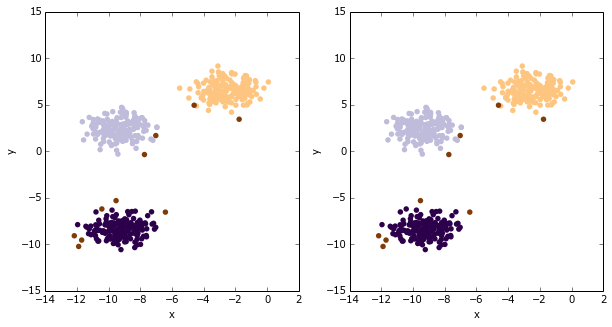

In [45]:
pred_blobs = Clustering(eps=0.8, min_pts=5).fit_predict(blobs)
good_pred = sc.DBSCAN(eps=0.8, min_samples=5).fit_predict(blobs)

print "Adjusted Rand index for blobs is: %.2f" % smt.adjusted_rand_score(y, pred_blobs)
print "Adjusted Rand index for sklearn implementation is: %.2f" % smt.adjusted_rand_score(y, good_pred)

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(blobs[:, 0], blobs[:, 1], c=pred_blobs, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('x')
plt.ylabel('y')

pl.subplot(1, 2, 2)
pl.scatter(blobs[:, 0], blobs[:, 1], c=good_pred, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('x')
plt.ylabel('y')
pl.show()

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [86]:
def intra_cluster_distance(distance_row, labels, i):
    mask = labels == labels[i]
    mask[i] = 0
    if not np.any(mask):
        return 0
    return np.mean(distance_row[mask])

def nearest_cluster_distance(distance_row, labels, i):
    label = labels[i]
    return np.min([np.mean(distance_row[labels == cur_label])
               for cur_label in set(labels) if not cur_label == label])

def quality(X, y):
    #Silhouette
    n_labels = len(np.unique(y))
    n_samples = len(X)
    if not 1 < n_labels < n_samples:
        return -1
    
    distance_matrix = ss.distance.squareform(ss.distance.pdist(X))
    A = np.array([intra_cluster_distance(distance_matrix[i], y, i) for i in range(len(y))])
    B = np.array([nearest_cluster_distance(distance_matrix[i], y, i) for i in range(len(y))])
    return np.mean((B - A) / np.maximum(A, B))

In [87]:
sklearn_silhouette = smt.silhouette_score(blobs, pred_blobs)
print sklearn_silhouette

my_silhouette = quality(blobs, pred_blobs)
print my_silhouette

0.733688277561
0.733688277561


Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

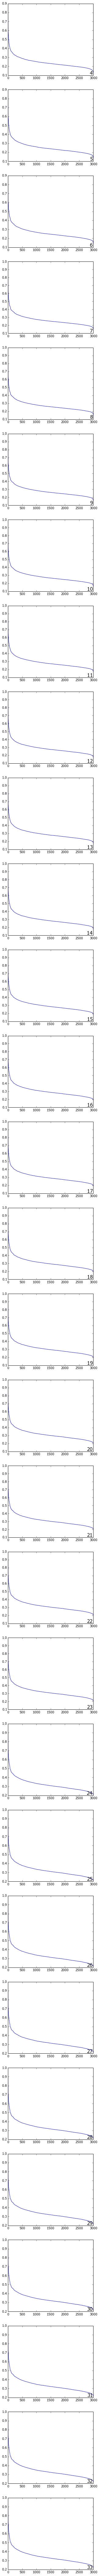

In [46]:
n = 30
pl.figure(figsize=(5, 5*n))
for k in xrange(4, n+4):
    dist = k_dist(x, k)
    pl.subplot(n, 1, k-3)
    pl.plot(dist)
    plt.text(.99, .01, k,
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
    
pl.show()

[-1.         -0.21831777  0.18397616  0.27922187  0.35189294  0.35189294
  0.35189294  0.        ]


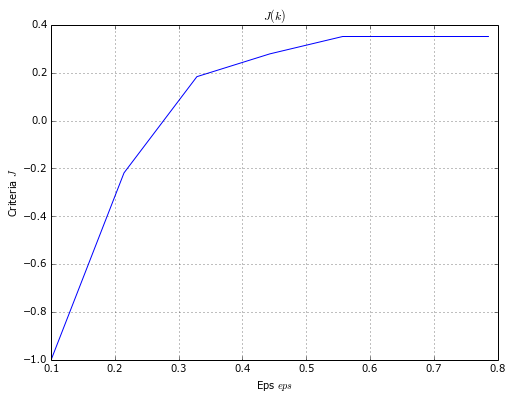

In [97]:
eps_array = np.linspace(0.1, 0.9, 8)
print criteria

pl.figure(figsize=(8, 6))
pl.plot(x[:-1], criteria[:-1])
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Eps $eps$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [99]:
eps = 0.3
min_pts = 10
cls = Clustering(eps=eps, min_pts=min_pts)
y = cls.fit_predict(x)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

In [100]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2999
[t-SNE] Computed conditional probabilities for sample 2000 / 2999
[t-SNE] Computed conditional probabilities for sample 2999 / 2999
[t-SNE] Mean sigma: 0.138063
[t-SNE] Error after 83 iterations with early exaggeration: 19.976084
[t-SNE] Error after 321 iterations: 2.131596


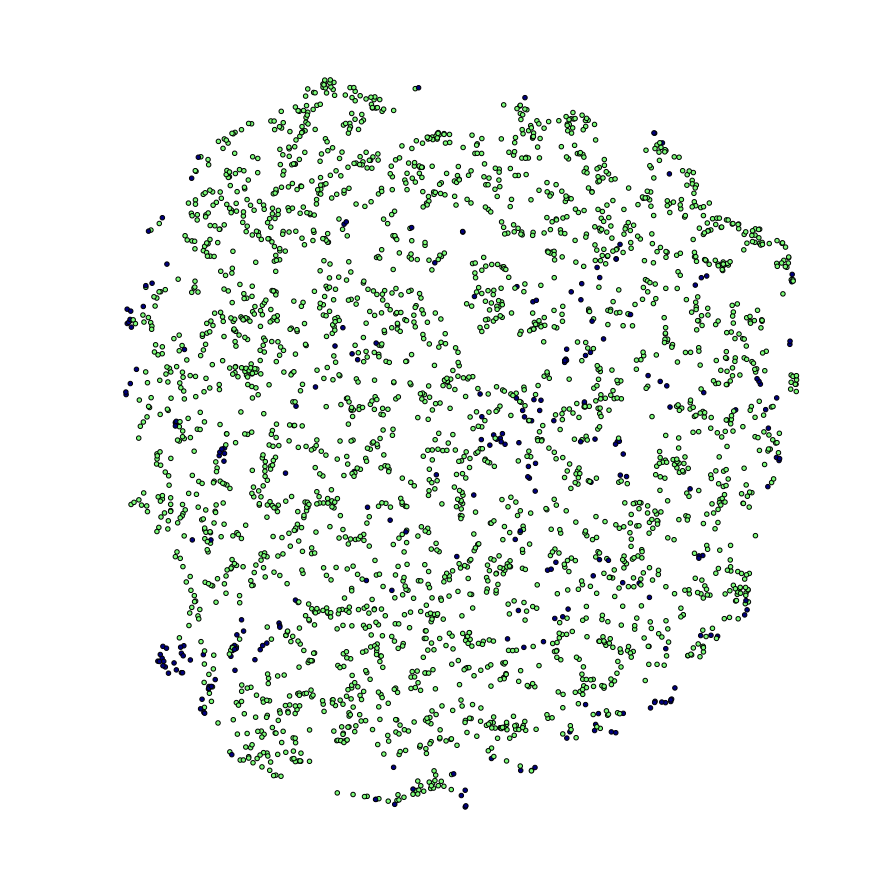

In [118]:
# Color map
cm = pl.get_cmap('jet')
k = len(np.unique(y))

pl.figure(figsize=(15, 15))

pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * (c + 1)/ k), y)) 
#pl.scatter(z[:, 0], z[:, 1], c=y, cmap=pl.cm.prism)
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

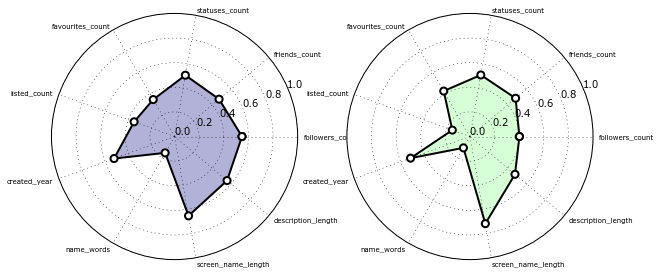

In [113]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
k = len(clusters)

for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.